<h1 style = "font-size:3rem;color:darkcyan"> Train Classifier</h1>


In [34]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import json
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [35]:
# import dataset
def import_dataset(dataset_path):
    with open(dataset_path, 'r') as f:
        data = json.load(f)
        
    # split data
    
    # split list into different np arrays
    mappings = np.array(data['mappings']) 
    inputs = np.array(data['MFCC'])
    targets = np.array(data['labels'])
    filenames = np.array(data['filenames'])
    
    return mappings, inputs, targets, filenames

In [72]:
mappings, inputs, targets, filenames = import_dataset('data.json')

In [74]:
# adjusting the input shape for CNN compatibility (from 2D to 3D (excluding # samples))
print('input shape before: {}'.format(inputs.shape))
inputs = inputs[..., np.newaxis] 
print('input shape after: {}'.format(inputs.shape))

input shape before: (30000, 94, 13)
input shape after: (30000, 94, 13, 1)


In [75]:
# splitting data into train, validation, and testing sets
# filenames for misclassification-tracking

def train_validation_test_split(x, y, filenames, test_size = 0.25, val_size = 0.2):
    if (0 < test_size < 1)  and (0 < val_size < 1):
        train_size = 1 - test_size - val_size
        if train_size > 0:

            # train test split
            (
            x_train, x_test, 
            y_train, y_test,
            fn_train, fn_test
            ) = train_test_split(x, y, filenames, test_size = test_size)

            #train validation split
            (
            x_train, x_val, 
            y_train, y_val, 
            fn_train, fn_val
            ) = train_test_split(x_train, y_train, fn_train, test_size = val_size)

            return x_train, x_val, x_test, y_train, y_val, y_test, fn_train, fn_val, fn_test
        else: 
            print('train size is too small, adjust test and validation sizes')
            return
    else:
        print('test and validation size should be between 0 and 1!')
        return

In [76]:
# split data into train, validation and test sets
(
x_train, x_val, x_test,
y_train, y_val, y_test,
fn_train, fn_val, fn_test
) = train_validation_test_split(inputs, targets, filenames, test_size = 0.25, val_size = 0.2)

In [77]:
print(type(targets[0]))
print(type(inputs[0]))
print(type(mappings[0]))



<class 'numpy.int32'>
<class 'numpy.ndarray'>
<class 'numpy.str_'>


In [78]:
def build_CNN_model(input_shape, output_len):
    # create model
    model = keras.Sequential()
    
    # 1st CNN layer
    model.add(keras.layers.Conv2D(64, (3,3), activation = 'relu',
                                  input_shape = input_shape,
                                  kernel_regularizer = keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
    
    
    # 2nd CNN layer
    model.add(keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
   
              
    # 3rd CNN layer
    model.add(keras.layers.Conv2D(32, (2,2), activation = 'relu', input_shape = input_shape, kernel_regularizer = keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((2,2), strides = (2,2), padding = 'same'))
              
    # flatten layer & feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation = 'relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # output layer
    model.add(keras.layers.Dense(output_len, activation = 'softmax'))
    
    return model
    

In [79]:
# build model
input_shape = [inputs.shape[1], inputs.shape[2], inputs.shape[3]]
model = build_CNN_model(input_shape, len(mappings))

In [80]:
# compile model
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer = optimizer,
             loss='sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [81]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 92, 11, 64)        640       
                                                                 
 batch_normalization_15 (Bat  (None, 92, 11, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 6, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 44, 4, 32)         18464     
                                                                 
 batch_normalization_16 (Bat  (None, 44, 4, 32)        128       
 chNormalization)                                                
                                                      

In [82]:
# train model
history = model.fit(x_train, y_train,
                   validation_data = (x_val, y_val),
                   batch_size = 32, 
                   epochs = 30)

Epoch 1/30
563/563 [==============================] - 14s 23ms/step - loss: 1.1012 - accuracy: 0.6838 - val_loss: 0.3285 - val_accuracy: 0.9444
Epoch 2/30
563/563 [==============================] - 12s 22ms/step - loss: 0.3320 - accuracy: 0.9278 - val_loss: 0.1705 - val_accuracy: 0.9747
Epoch 3/30
563/563 [==============================] - 13s 23ms/step - loss: 0.2070 - accuracy: 0.9649 - val_loss: 0.1340 - val_accuracy: 0.9858
Epoch 4/30
563/563 [==============================] - 13s 23ms/step - loss: 0.1648 - accuracy: 0.9759 - val_loss: 0.1092 - val_accuracy: 0.9911
Epoch 5/30
563/563 [==============================] - 14s 24ms/step - loss: 0.1392 - accuracy: 0.9822 - val_loss: 0.1028 - val_accuracy: 0.9909
Epoch 6/30
563/563 [==============================] - 14s 24ms/step - loss: 0.1207 - accuracy: 0.9872 - val_loss: 0.1061 - val_accuracy: 0.9884
Epoch 7/30
563/563 [==============================] - 13s 22ms/step - loss: 0.1120 - accuracy: 0.9886 - val_loss: 0.0940 - val_accuracy:

In [83]:
 def plot_training_history(history, figsize = [15,6]):
    
    fig, ax = plt.subplots(2, figsize=figsize)
    
    # create accuracy subplot
    ax[0].plot(history.history['accuracy'], label = 'Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].set_title('Accuracy Evaluation')
    
    # create error subplot
    ax[1].plot(history.history['loss'], label = 'Training Error')
    ax[1].plot(history.history['val_loss'], label = 'Validation Error')
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Error Evaluation')
    
    plt.show()

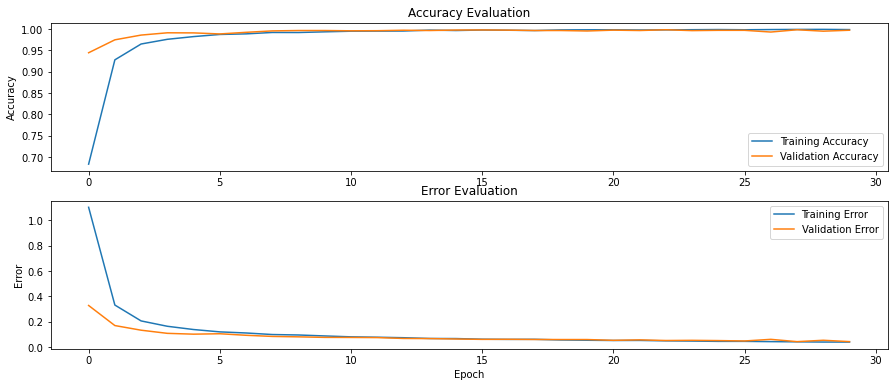

In [84]:
plot_training_history(history)

In [85]:
# test model accuracy:
test_error, test_accuracy = model.evaluate(x_test, y_test, verbose = True)
print('Model loss = {} | model accuracy = {}'.format(test_error, test_accuracy))

235/235 [==============================] - 1s 6ms/step - loss: 0.0538 - accuracy: 0.9955
Model loss = 0.05378219485282898 | model accuracy = 0.9954666495323181


In [86]:
# get predictions
y_pred = model.predict(x_test)
pred_classes = np.argmax(y_pred, axis=1)

235/235 [==============================] - 1s 6ms/step


In [87]:
# visualize confusion matrix

def plot_confusion_matrix(true_target, predicted_target, classes, normalize = None, cmap= 'PuBu', size = [6,6], fontsize=9):
    # get confusion matrix
    labels = np.arange(0,len(classes), 1)
    cm = sklearn.metrics.confusion_matrix(true_target, predicted_target, labels = labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Absolute Confusion Matrix'
        
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)
    
    
    # set labels ticks
    ticks = np.arange(cm.shape[1])
    ax.set(xticks=ticks,
           yticks=ticks,
           xticklabels=classes, 
           yticklabels=classes,
          )
    
    ax.set_title(title, fontsize = 20)
    ax.set_ylabel('True Class', fontsize = fontsize)
    ax.set_xlabel('Predicted Class', fontsize = fontsize)
     
    # style tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", color = 'darkgrey', fontsize = fontsize)
    plt.setp(ax.get_yticklabels(), ha="right",
             rotation_mode="anchor", color = 'darkgrey', fontsize = fontsize)
    
    # plot text annotation inside each segment
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize = fontsize)

    fig.tight_layout()
    plt.show()

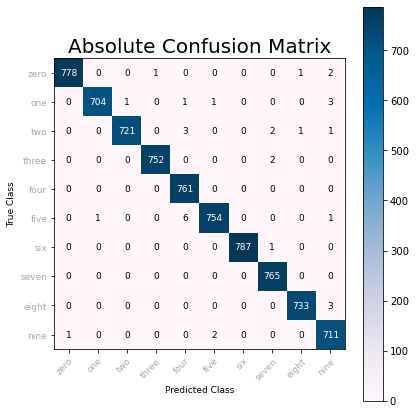

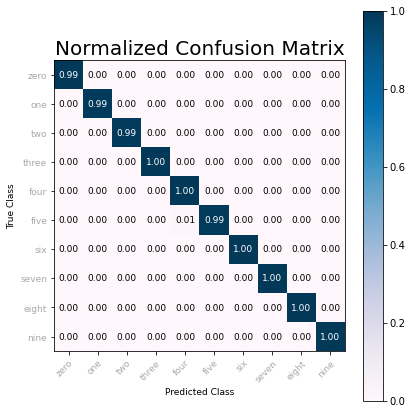

In [88]:
plot_confusion_matrix(y_test, pred_classes, classes = mappings, normalize = False)
plot_confusion_matrix(y_test, pred_classes, classes = mappings, normalize = True)

In [89]:
matches = pred_classes != y_test
print('Number of misclassified audiofiles = {} / {}'.format(np.count_nonzero(matches), len(y_pred)))
print('\nMisclassifed files:')
#displaying names of misclassified files
for i in range(len(y_test)):
    if pred_classes[i] != y_test[i]:
        print('{: <25} {: <10}  classified as {}'.format(fn_test[i], '(' + mappings[y_test[i]] + ')', mappings[pred_classes[i]]))

Number of misclassified audiofiles = 34 / 7500

Misclassifed files:
9_47_17.wav               (nine)      classified as five
8_18_22.wav               (eight)     classified as nine
0_19_22.wav               (zero)      classified as three
8_19_35.wav               (eight)     classified as nine
1_60_23.wav               (one)       classified as nine
2_44_17.wav               (two)       classified as nine
5_27_44.wav               (five)      classified as nine
0_26_26.wav               (zero)      classified as eight
2_42_12.wav               (two)       classified as four
1_35_40.wav               (one)       classified as four
1_60_48.wav               (one)       classified as nine
5_37_26.wav               (five)      classified as four
5_46_23.wav               (five)      classified as four
9_47_11.wav               (nine)      classified as zero
2_15_37.wav               (two)       classified as four
2_32_29.wav               (two)       classified as seven
9_23_14.wav      